In [1]:
!python3 -m pip install git+https://github.com/deepmind/dm-haiku
!python3 -m pip install optax

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-gfkromyg
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-gfkromyg
Defaulting to user installation because normal site-packages is not writeable


In [2]:
!git clone https://github.com/chao1224/BadGlobalMinima

Cloning into 'BadGlobalMinima'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 29 (delta 1), reused 5 (delta 0), pack-reused 20
Unpacking objects: 100% (29/29), done.


In [3]:
!pip install tensorflow-datasets

Defaulting to user installation because normal site-packages is not writeable


In [37]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
import seaborn as sns
sns.set()
%load_ext autoreload
%autoreload 2

In [5]:
import haiku as hk
import optax
import jax
import jax.numpy as jnp
import tree
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import NamedTuple
# from BadGlobalMinima.notebooks.resnet import ResNet18

AUGMENTATION = True
ADVERSARIAL = True

In [11]:
import numpy as np

In [110]:
from torchvision import transforms
normalize_transform = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

augmentantion_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_transform
    ,
])

standard_transforms = transforms.Compose([
    transforms.ToTensor(),
    normalize_transform
])

In [100]:
import torch
from torch.utils.data import Dataset

class AdversarialCIFAR(Dataset):
    pass
    

class AdversarialDataset(Dataset):
    def __init__(self, original_images, n_classes, R, zero_out_ratio, random_state):
        self.n_classes = n_classes
        self.R = R
        self.zero_out_ration = zero_out_ratio

        np.random.seed(random_state)
        
        self.n = original_images.shape[0]*R
        self.y = np.random.randint(n_classes, size=self.n)
        self.x = np.repeat(original_images, R, axis=0)
        
        # Add noise to x
        # The authors perform per RGB value zeroing-out; NOT per pixel
        # https://github.com/chao1224/BadGlobalMinima/blob/950b0c0e2dc0ab2bda5077e81e6ad317e87c5a18/cifar10/cifar10_data/confusion_data_generation.py#L93
        if zero_out_ratio > 0:
            flatten_x = self.x.reshape(self.x.shape[0], -1)
            n_pos = flatten_x.shape[1]
            n_per_image_zeros = int(zero_out_ratio*n_pos)

            img_idx = np.repeat(np.arange(self.n), n_per_image_zeros)
            pos_idx = np.random.randint(n_pos, size=(self.n*n_per_image_zeros))

            flatten_x[img_idx, pos_idx] = 0
            self.x = flatten_x.reshape(self.x.shape)
            
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.n

In [102]:
adv_data = AdversarialDataset(x, 10, 1, 0.1, 42)

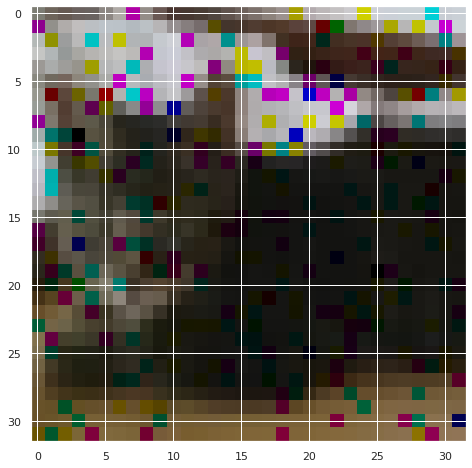

In [108]:
plt.imshow(adv_data[-1][0])

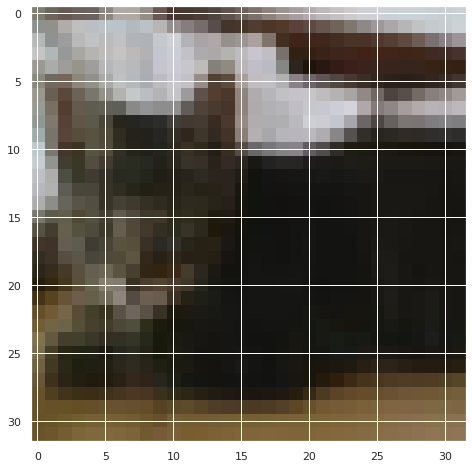

In [107]:
plt.imshow(x[-1])

In [ ]:
array_x[[0, 1, 2], []]

In [90]:
zero_out_ratio = 0.1


NameError: name 'self' is not defined

In [88]:
array_x.shape, x.shape

((10, 32, 32, 3), (10, 32, 32, 3))

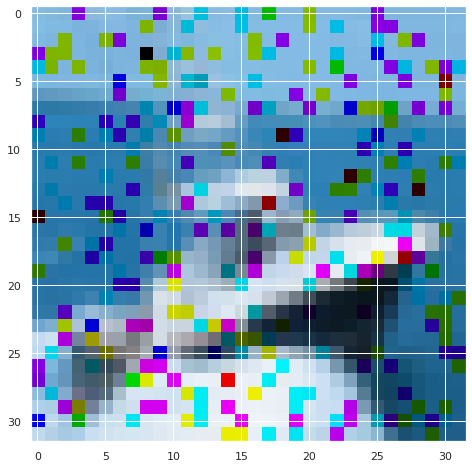

In [89]:
plt.imshow(array_x[-2])

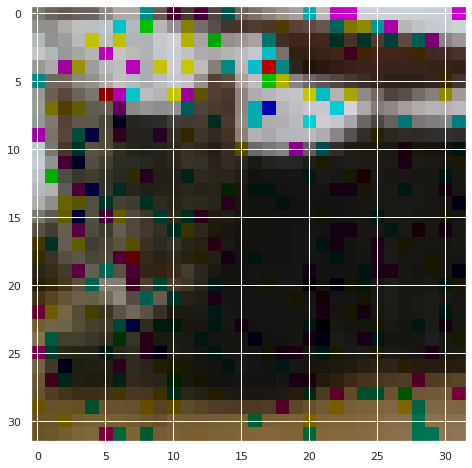

In [85]:
plt.imshow(array_x[-1])

In [28]:
from torchvision.datasets import cifar
#np.tile(x, 10)

In [31]:
data = cifar.CIFAR10(".", download=True)


Extracting ./cifar-10-python.tar.gz to .


In [33]:
x = data.data[:10]

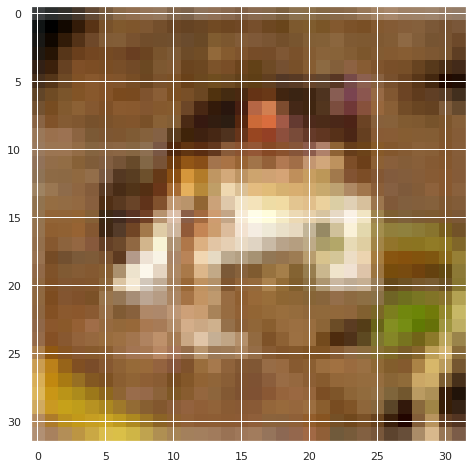

In [38]:
plt.imshow(x[0])

In [52]:
temp_x = np.repeat(x, 3, axis=0)
temp_x.shape


(30, 32, 32, 3)

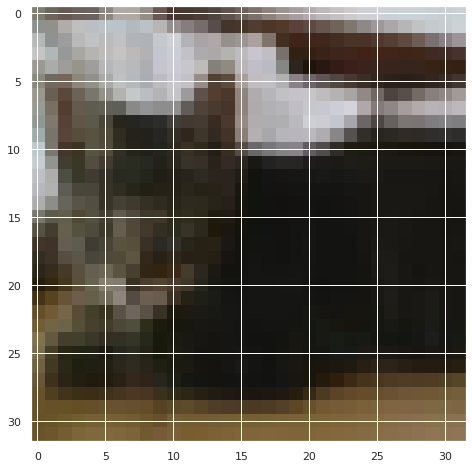

In [53]:
plt.imshow(temp_x[-2])

In [36]:
plt.im

(10, 32, 32, 3)

In [16]:
np.random.randint(1)

0

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [7]:
key1 = jax.random.PRNGKey(0)

if (ADVERSARIAL):
    y_train = jax.random.permutation(key1, y_train)

In [27]:
# We need ds_info for the next cell
(train_ds, test_ds), ds_info = tfds.load('cifar10', 
                                         split=['train', 'test'], 
                                         shuffle_files=True, 
                                         with_info=True)

train_ds = tf.data.Dataset.from_tensor_slices({"image": x_train, "label": y_train})


# fig = tfds.show_examples(train_ds, ds_info)

In [28]:
def preprocess(example):
    image, label = example['image'], example['label']

    if (AUGMENTATION):
        # Data augmentation
        image = tf.image.resize_with_crop_or_pad(image, 170, 170) # Adiciona 10 pixels
        image = tf.image.random_crop(image, size=[160, 160, 3]) # Corta de volta para 160
        image = tf.image.random_flip_left_right(image) 

    image = tf.cast(image, tf.float32)/255.0
    return {'image': image, 'label': label}

In [29]:
train_ds = train_ds.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_ds = train_ds.cache()
train_ds = train_ds.shuffle(ds_info.splits['train'].num_examples)
train_ds = train_ds.batch(128)
ds_numpy = tfds.as_numpy(train_ds)

In [34]:
def _forward(batch, is_training):
    """Forward application of the resnet."""
    images = batch['image']
    net = ResNet18(10,
                    bn_config={'decay_rate': 0.9})
    return net(images, is_training=is_training)

# Transform our forwards function into a pair of pure functions.
forward = hk.transform_with_state(_forward)

In [35]:
def make_optimizer():
    """SGD with momentum and a fixed lr."""
    return optax.chain(
      optax.trace(decay=0.9, nesterov=False), #momentum
      optax.scale(-1e-3))

In [36]:
def l2_loss(params):
    return 0.5 * sum(jnp.sum(jnp.square(p)) for p in params)

In [37]:
class TrainState(NamedTuple):
    params: hk.Params
    state: hk.State
    opt_state: optax.OptState

In [53]:
def loss_fn(params, state, batch):
    """Computes a regularized loss for the given batch."""
    logits, state = forward.apply(params, state, None, batch, is_training=True)
    labels = jax.nn.one_hot(batch['label'], 10)
    logits = logits.reshape(len(labels), 1, 10)  # match labels shape
    loss = optax.softmax_cross_entropy(logits=logits, labels=labels).mean()
    
    l2_params = [p for ((mod_name, _), p) in tree.flatten_with_path(params)
                 if 'batchnorm' not in mod_name]
    loss = loss + 1e-4 * l2_loss(l2_params)
    return loss, (loss, state)

In [49]:
@jax.jit
def train_step(train_state, batch):
    """Applies an update to parameters and returns new state."""
    params, state, opt_state = train_state
    grads, (loss, new_state) = (
        jax.grad(loss_fn, has_aux=True)(params, state, batch))
    
    # Compute and apply updates via our optimizer.
    updates, new_opt_state = make_optimizer().update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    
    train_state = TrainState(new_params, new_state, new_opt_state)
    return train_state, loss

In [50]:
def initial_state(rng, batch):
    """Computes the initial network state."""
    params, state = forward.init(rng, batch, is_training=True)
    opt_state = make_optimizer().init(params)
    return TrainState(params, state, opt_state)

In [51]:
epochs = 5
rng = jax.random.PRNGKey(0)
batch = next(iter(ds_numpy))
train_state = initial_state(rng, batch)

In [54]:
for _ in range(epochs):
    total_losses = []
    for batch in ds_numpy:
        train_state, loss = train_step(train_state, batch)
        total_losses.append(loss)
    print(sum(total_losses)/len(total_losses))

KeyboardInterrupt: 